In [105]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv


# Objective: Predict employee churn rates and understand which factors lead to attrition 

Data Source: IBM HR Analytics Employee Attrition & Performance (https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset) 


In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score,log_loss,classification_report)

#Import and suppress warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
! jupyter nbconvert --to html your_notebook_name.ipynb.

In [107]:
#load data
data = pd.read_csv('../input/ibm-hr-analytics-attrition-dataset/WA_Fn-UseC_-HR-Employee-Attrition.csv')

In [108]:
#preview data
data.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,...,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,...,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,...,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,...,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,...,4,80,1,6,3,3,2,2,2,2


# Exploratory Data Analysis and Visualizations

In [109]:
data.shape

(1470, 35)

In [110]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

We have both numerical and categorical variables so we will need to use LabelEncoder to numerically encode the categorical variables 

Let's drop EmployeeCount, EmployeeNumber, over18 and StandardHours and these variabls do not provide any useful information (are constant throughout the dataset) 

In [111]:
data.drop(['EmployeeCount','EmployeeNumber','Over18','StandardHours'],axis=1,inplace=True)

In [112]:
#check columns were dropped
data.shape

(1470, 31)

In [113]:
#convert target variable to numerical
map = {'Yes':1,'No':0}
data['Attrition_num'] = data['Attrition'].apply(lambda x:map[x])

data.drop(['Attrition'], axis=1,inplace=True)

In [114]:
data['Attrition_num'].dtype

dtype('int64')

In [115]:
#identify categorical variables
categorical = [x for x in data.columns if data[x].dtype == 'object']
print(categorical)
print(len(categorical))

['BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus', 'OverTime']
7


In [116]:
#identify numerical variables
numerical = [x for x in data.columns if data[x].dtype == 'int64']
print(numerical)
print(len(numerical))

['Age', 'DailyRate', 'DistanceFromHome', 'Education', 'EnvironmentSatisfaction', 'HourlyRate', 'JobInvolvement', 'JobLevel', 'JobSatisfaction', 'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction', 'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear', 'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion', 'YearsWithCurrManager', 'Attrition_num']
24


In [117]:
#check missing values
data.isnull().sum()

Age                         0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
Attrition_num               0
dtype: int64

There are no missing entries which will make the data processing and cleaning much simpler

# Univariate Analysis: 

Understanding the target variable and its distribution

In [118]:
attrition = data['Attrition_num'].value_counts()
print(attrition)
print(attrition/len(data)*100)

0    1233
1     237
Name: Attrition_num, dtype: int64
0    83.877551
1    16.122449
Name: Attrition_num, dtype: float64


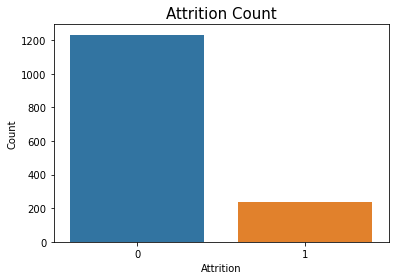

In [140]:
sns.barplot(x= attrition.index, y=attrition.values)
plt.xlabel('Attrition')
plt.ylabel('Count')
plt.title('Attrition Count', size=15)
plt.show()

Our target variable/data set is imbalanced, we will need to perform a tactic to combat the imbalanced classes 

# Multivariate Analysis: 

Understanding the relationships, patterns and correlations between variables 

Distribution of numerical variables

We need to understand the correlations between our numerical variables and our target variable (attrition) 

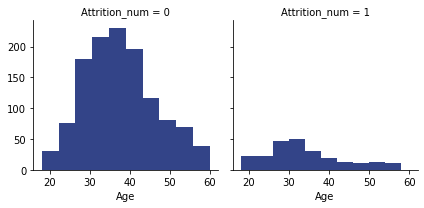

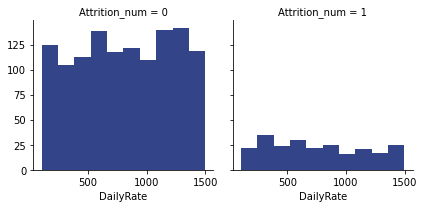

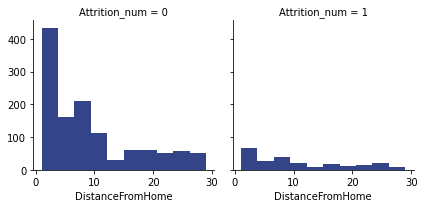

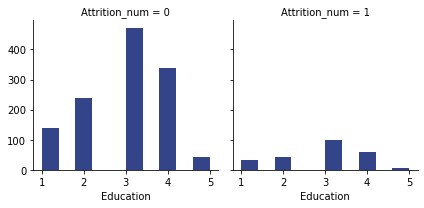

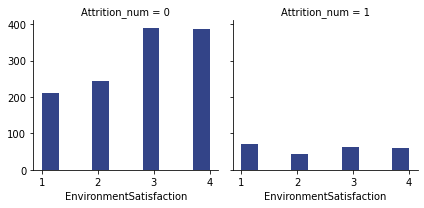

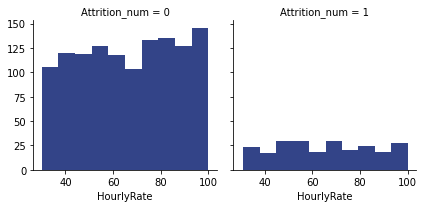

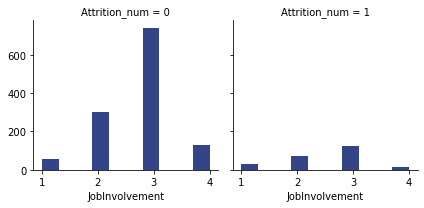

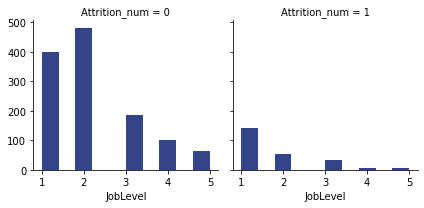

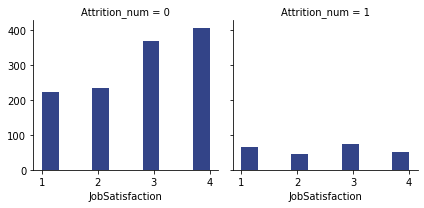

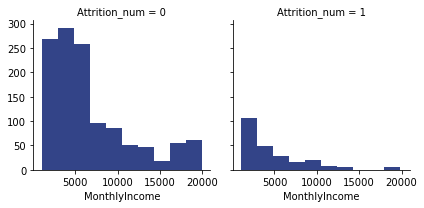

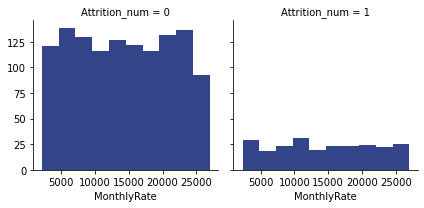

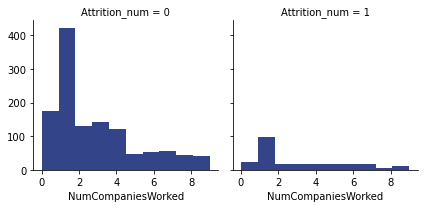

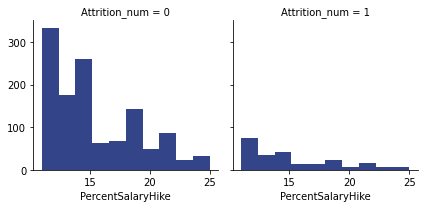

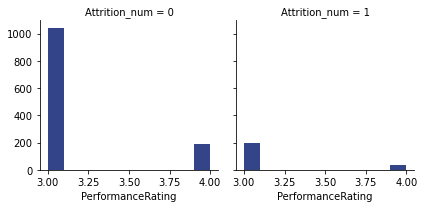

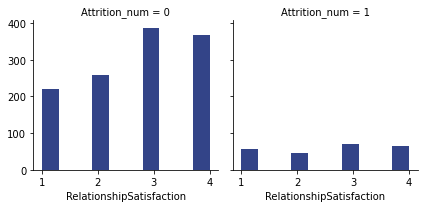

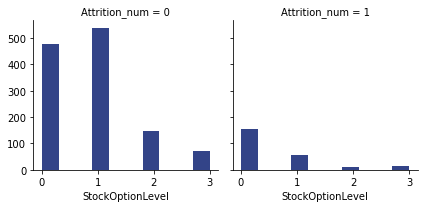

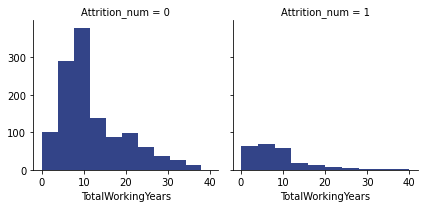

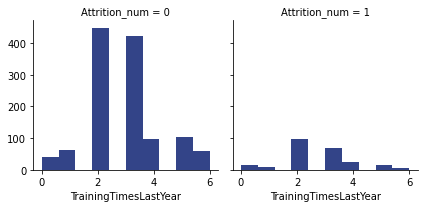

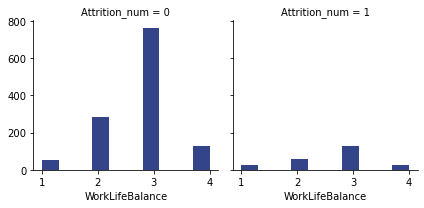

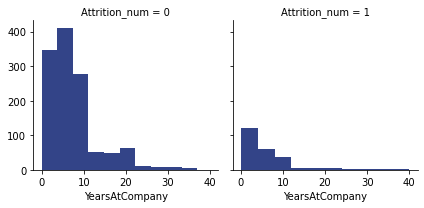

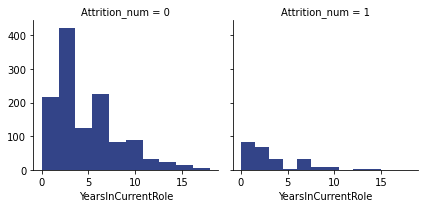

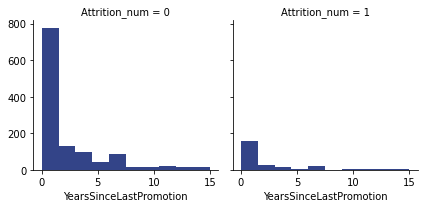

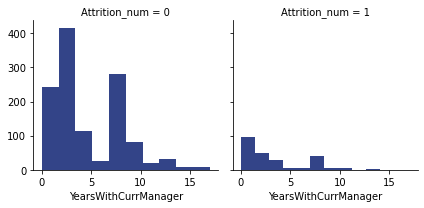

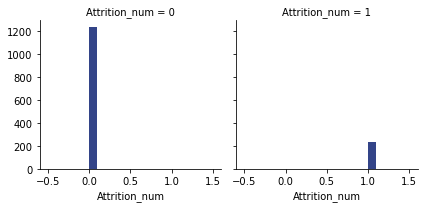

In [120]:
for var in numerical:
    g = sns.FacetGrid(data, col='Attrition_num')
    g.map(plt.hist, var, color="#334488")

Most of the numerical variables have correlations, some notable ones include Age, Distance from Home, Education, Job Involvement, Monthly Income, Percent Salary Hike, Performance Rating, StockOptionLevel, YearsAtCompany

In [121]:
data.describe()

,Age,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,...,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_num
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,...,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,...,2.712245,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129,0.161224
std,9.135373,403.509100,8.106864,1.024165,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,...,1.081209,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136,0.367863
min,18.000000,102.000000,1.000000,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,...,2.000000,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000,0.000000
50%,36.000000,802.000000,7.000000,3.000000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,...,3.000000,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000,0.000000
75%,43.000000,1157.000000,14.000000,4.000000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,...,4.000000,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000,0.000000
max,60.000000,1499.000000,29.000000,5.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,...,4.000000,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000,1.000000


Correlating categorical variables:

In [122]:
def create_cat():
    for var in categorical:
        print(data[[var,'Attrition_num']].groupby([var]).mean())
 
create_cat()

                   Attrition_num
BusinessTravel                  
Non-Travel              0.080000
Travel_Frequently       0.249097
Travel_Rarely           0.149569
                        Attrition_num
Department                           
Human Resources              0.190476
Research & Development       0.138398
Sales                        0.206278
                  Attrition_num
EducationField                 
Human Resources        0.259259
Life Sciences          0.146865
Marketing              0.220126
Medical                0.135776
Other                  0.134146
Technical Degree       0.242424
        Attrition_num
Gender               
Female       0.147959
Male         0.170068
                           Attrition_num
JobRole                                 
Healthcare Representative       0.068702
Human Resources                 0.230769
Laboratory Technician           0.239382
Manager                         0.049020
Manufacturing Director          0.068966
Research Direc

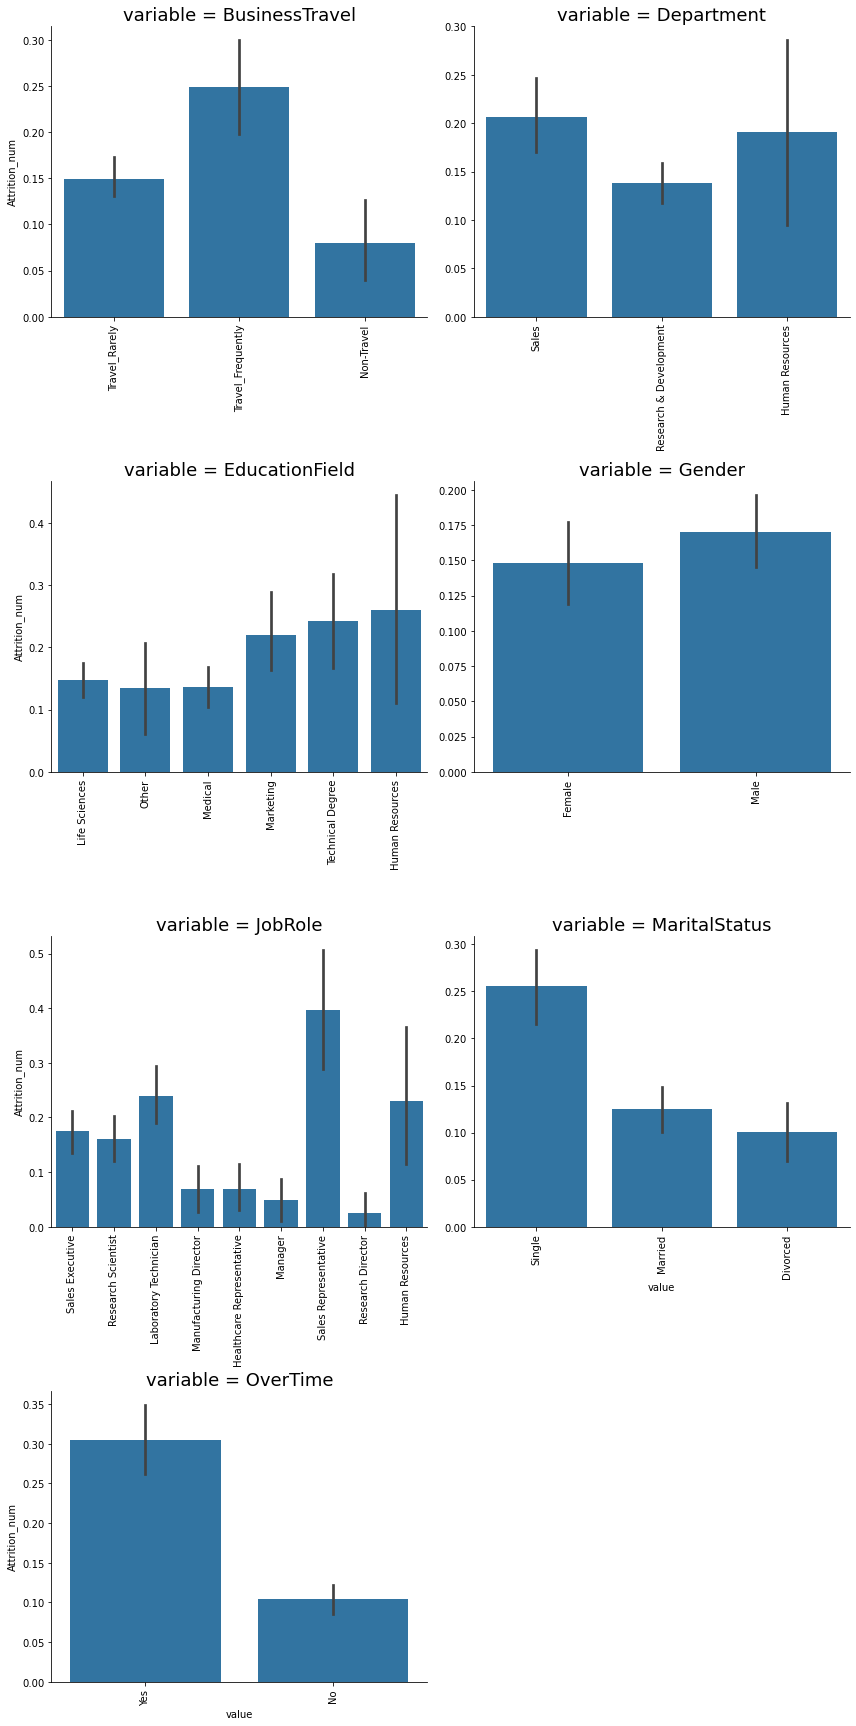

In [123]:
f = pd.melt(data, id_vars=['Attrition_num'], value_vars=categorical)
g = sns.FacetGrid(f, col="variable", col_wrap=2, sharex=False, sharey=False, size=6, height=1)
g = g.map(sns.barplot, "value","Attrition_num")
g.set_xticklabels(rotation=90) 
g.fig.tight_layout()
g.set_titles(size=18)

Observations:

* Frequent travelers have higher churn numbers than those who rarely or never travel
* Employees in Research & Development are more likely to stay compared to the two other Departments
* Human Resources has a higher attrition count than other education fields
* Men have higher attrition numbers than women
* Sales Representatives have the highest attrition rate for job roles
* Single employees are more likey to leave than married or divorced employees
* Longer hours seem to lead to higher attrition

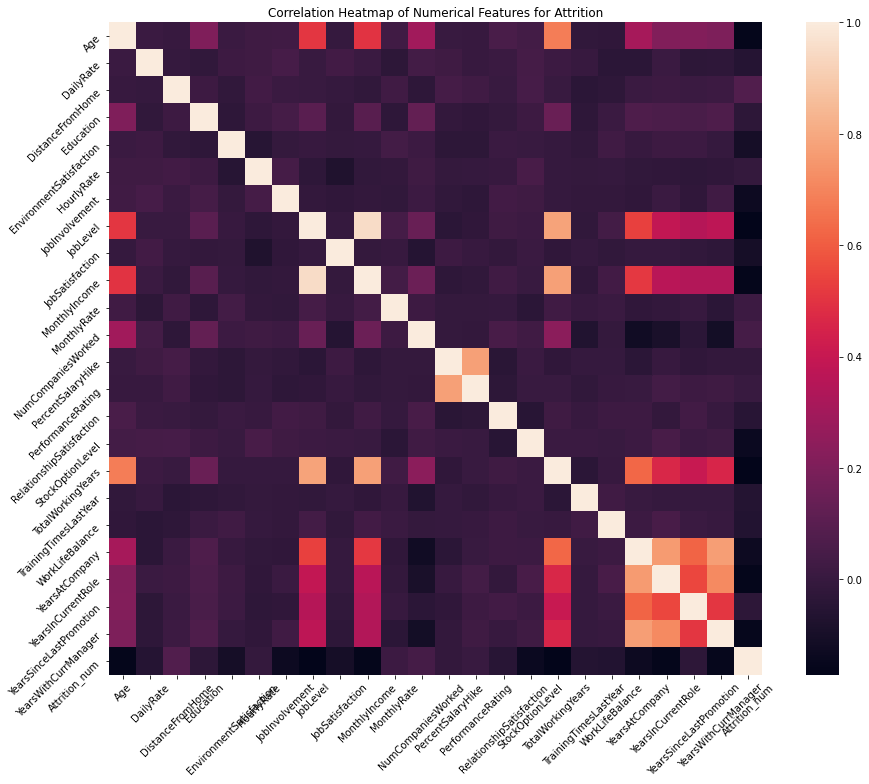

In [124]:
correlation = data[numerical].corr()

plt.figure(figsize=(16,12))
plt.title('Correlation Heatmap of Numerical Features for Attrition')
ax = sns.heatmap(correlation, square=True, annot=False)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_yticklabels(ax.get_yticklabels(),rotation=45)
plt.show()

#Given that this is an imbalanced dataset, our correlation matrix is affected. We will redo the correlation matrix once we address the imbalance


# Feature Engineering and Data Processing

In [125]:
y = data['Attrition_num']
X = data.drop('Attrition_num',axis=1)

Split the data before any processing or transformation to avoid data leakage

In [126]:
from sklearn.model_selection import train_test_split 

X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [127]:
X_train.shape, X_test.shape

((1176, 30), (294, 30))

In [128]:
#Encode categorical variables

from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
for var in categorical:
    X_train[var] = label.fit_transform(X_train[var])
    X_test[var] = label.transform(X_test[var])

In [129]:
X_train.shape

(1176, 30)

In [130]:
X_test.shape

(294, 30)

# Machine Learning Model Implementation

We'll build a baseline model first and then improve on it

In [131]:
from sklearn.ensemble import RandomForestClassifier

#instantiate the classifier
rfc= RandomForestClassifier(random_state=0,n_estimators=100)

#fit the model
rfc.fit(X_train, y_train)

#predict results
y_pred = rfc.predict(X_test)

In [132]:
#Check accuracy score

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(accuracy_score(y_test, y_pred))


cm = confusion_matrix(y_test, y_pred)

print(cm)
print(classification_report(y_test, y_pred))

print('-----------------')
print('Precision Score: {0:05f}' .format(precision_score(y_test,y_pred)))
print('Recall Score: {0:05f}' .format(recall_score(y_test,y_pred)))
print('F1 Score: {0:05f}' .format(f1_score(y_test, y_pred)))

0.8469387755102041
[[243   2]
 [ 43   6]]
              precision    recall  f1-score   support

           0       0.85      0.99      0.92       245
           1       0.75      0.12      0.21        49

    accuracy                           0.85       294
   macro avg       0.80      0.56      0.56       294
weighted avg       0.83      0.85      0.80       294

-----------------
Precision Score: 0.750000
Recall Score: 0.122449
F1 Score: 0.210526


Since this is an imbalanced dataset, accuracy will not be a good metric to evaluate. Instead we can use f1-score or confusion matrix/precision & recall score. The reason accuracy is not a good score is that given the imbalance if we just guessed they all remained, we would achieve 83.877551% accuracy, meaning our model only slighly performed better than this. 

# Model Improvement

Ways to improve model:
* Address oversampling issue through SMOTE

* Hyperparameter tuning:
* n_estimators hyperparameter: number of trees the algorithm builds before taking the max vote or taking the averages of predictions
* max_features: maximum number of features random forests considers to split a node
* min_sample_leaf: determines the min number of leafs required to split an internal node 

* Better Feature Engineering and Feature Selection 

Using SMOTE to address imbalance: Important to split the data first, because we only need the balanced data to train and we will still keep the imbalanced data to test

In [133]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=0)
smote_X,smote_y = oversampler.fit_sample(X_train,y_train)

In [134]:
smote_data = pd.concat([smote_X,smote_y])

In [135]:
smote_X

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,58,2,605,2,21,3,1,4,0,72,...,3,3,1,29,2,2,1,0,0,0
1,45,2,950,1,28,3,5,4,1,97,...,4,4,1,8,3,3,5,4,0,3
2,40,2,300,2,26,3,2,3,1,74,...,3,2,1,8,3,2,7,7,7,5
3,36,0,1434,2,8,4,1,1,1,76,...,3,2,0,10,1,3,10,7,0,9
4,25,1,599,2,24,1,1,3,1,73,...,3,4,0,1,4,3,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1971,41,2,619,1,1,4,2,1,0,54,...,3,2,0,21,2,1,19,2,8,7
1972,29,1,448,0,5,3,4,2,1,42,...,3,3,0,3,3,3,1,0,0,0
1973,30,1,410,1,22,3,1,1,0,56,...,3,1,0,11,2,2,3,1,0,2
1974,38,1,858,1,13,3,4,2,1,57,...,3,3,0,4,3,2,1,0,0,0


In [136]:
#verifty the new data is balanced
smote_y.value_counts()

1    988
0    988
Name: Attrition_num, dtype: int64

In [137]:
rfc= RandomForestClassifier(random_state=0)

#fit the model
rfc.fit(smote_X, smote_y)

#predict results
y_pred2 = rfc.predict(X_test)

In [138]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print(accuracy_score(y_test, y_pred2))


cm = confusion_matrix(y_test, y_pred2)

print(cm)
print(classification_report(y_test, y_pred2))

print('-----------------')
print('Precision Score: {0:05f}' .format(precision_score(y_test,y_pred2)))
print('Recall Score: {0:05f}' .format(recall_score(y_test,y_pred2)))
print('F1 Score: {0:05f}' .format(f1_score(y_test, y_pred2)))


0.8435374149659864
[[231  14]
 [ 32  17]]
              precision    recall  f1-score   support

           0       0.88      0.94      0.91       245
           1       0.55      0.35      0.42        49

    accuracy                           0.84       294
   macro avg       0.71      0.64      0.67       294
weighted avg       0.82      0.84      0.83       294

-----------------
Precision Score: 0.548387
Recall Score: 0.346939
F1 Score: 0.425000


Precision went down but Recall went up. Precision is more important than recall when we would like to have less False Prositives, meaning getting a False Positive is very costly and a False Negative less so. False Positive in this context means we incorrectly predicted the employee would churn, when they actually remained. Recall is the fraction of all exisiting positives (churned employees) that we predicted correctly. The trade off between precision vs. recall can be better asssessed when taking into consideration budget allocations or initiatives taking place in order to retain employees. The F1 statistic is a harmonic mean of precision and recall  

# Next Steps (work in progress)

* Hyperparameter tuning via RandomizedSearchCV
* Crossvalidation 